# Data Wrangling on WeRateDogs



## Table of Contents
- [Introduction](#intro)
- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Acting](#acting)

<a id='intro'></a>
## Introduction

The main purpose of this project is to put into practice key concepts learnt during this module. Tasks that will be carrier out on the following notebook are gathering, assessing and cleaning data that has been provided to us using different means. In order to do so Python 3 will be used. Also the solution provided will lean on the following set of python libraries.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tweepy
import json
from timeit import default_timer as timer
%matplotlib inline

<a id='gather'></a>
## Gather    

The first step in data analysis is data gathering. In this case data gathering will be comprised of the following steps:   
**1.-** Import the tweeter archive for WeRateDogs into the workspace   
**2.-** Download image predictions data from a given URL   
**3.-** Gather data from the Tweeter API to collect more relevant information   

#### 1.- Import the tweeter archive
This file has already been provided as a manual download. As such, it's available locally and just need to import it using pandas read_csv method for reading flat files into a pandas dataframe. Then, output the first row to verify that it has loaded successfully.

In [8]:
archive_df = pd.read_csv("twitter_archive_enhanced.csv")
archive_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


#### 2.- Download image predictions data from a given URL   
Unlike the previous file, in this case the file's URL was given. Hence, we download the file programatically as this is less prone to errors and eases reproducibility.    
First download the file using python library **_requests_** and save the information downloaded in a file. Then, import the file similarly to how it was done in step \#1. Also output first row to verify everything has gone correctly. 

In [9]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
image_predictions = requests.get(url)
file_name = url.split('/')[-1]
with open(file_name, mode='w', encoding =image_predictions.encoding) as f:
    f.write(image_predictions.text)
image_df = pd.read_csv(file_name,sep='\t')
image_df.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


#### 3.- Gather data from Tweeter by accessing their API 
The third step for this data gathering effort is to obtain various pieces of data from Tweeter directly by using their API. Please note that keys and tokens are stored in a separate file that is stored locally and is not part of source control. As such, these fields will need to be edited if this notebook was to used different tweeter app credentials.    
The idea is to query Tweeter's API through python's api library for tweeter (Tweepy). The idea is to get some more information for each of the tweets we have in df_archive dataframe. Then store json content into a txt file. Once the json text file is available parse it and create a new dataframe to work under python environment. 
So let's first define the function that will be used to parse json text file into a dataframe

In [10]:
def parseJson():
    jsonlist = []
    with open('tweet_json.txt','r',encoding='utf-8') as fjsonRead:
        for line in fjsonRead:
            json_dict = json.loads(line)
            tweet_id = json_dict['id']
            retw_count = json_dict['retweet_count']
            fav_count = json_dict['favorite_count']
            jsonlist.append({'tweet_id':tweet_id, 'retw_count':retw_count, 'fav_count':fav_count})
    return pd.DataFrame(jsonlist,columns=['tweet_id', 'retw_count', 'fav_count'])

Downloading information from the API for so many tweets it's a time consuming task. Thus, we would not like to do it every time this notebook is run since this operation can take 30 minutes on its own. Therefore if the file is present, it's assumed that the API has already been queried and data stored in the file. If this was the case, then proceed with parsing the file into a dataframe. Otherwise, query the API and store data in a text file before parsing.

In [11]:
try:
    tweeter_df = parseJson()
except FileNotFoundError as e:
    start = timer()
    with open('tweet_json.txt','w',encoding='utf-8') as f:
        with open('tweetIdsFailed.txt','w',encoding='utf-8') as ffail:
            with open('tweeterKeys.txt','r',encoding='utf-8') as f:
                getData = lambda line: line.split(' ')[0]
                consumer_key = getData(f.readline())
                consumer_secret = getData(f.readline())
                access_token = getData(f.readline())
                access_secret = getData(f.readline())
                auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
                auth.set_access_token(access_token, access_secret)
                api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
                for row in archive_df['tweet_id']:
                    try:
                        tweet = api.get_status(row,tweet_mode='extended')
                        json.dump(tweet._json, f)
                        f.write('\n')
                    except tweepy.TweepError as e:
                        ffail.write(str(row)+'\n')
    end = timer()
    print('Time: {}'.format(end-start))
    tweeter_df = parseJson()
tweeter_df.head(1)

,tweet_id,retw_count,fav_count
0,892420643555336193,8366,38195


<a id='assess'></a>
## Assess

Once all data has been collected, we need to inspect each dataframe to find flaws in either contents or structure. Let's start with archive_df. Let's first have a general look by printing the info

In [13]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

The information above is filtered data from the 5000+ Tweeter account. It's filtered taking into account only those tweets that contain dog ratings. However as it can be seen above some of the tweets are **re**tweets and so we can regard these as duplicated information. We could verify that **retweeted_status_id** == tweet_id for other row in the dataframe. The problem here is that the type for column retweeted_status_id is float64. For example,

In [14]:
print (archive_df[archive_df['retweeted_status_id'].notnull()].retweeted_status_id.values[0],
       archive_df[archive_df['retweeted_status_id'].notnull()].retweeted_status_id.astype('int64').values[0])

8.874739571039519e+17 887473957103951872


To me the above results are wrong. The number on the left, in floating point arithmetic, contains only 15 decimal digits. The exponent however indicates 17. Therefore when casting to an **int64** type, somehow the last two digits are made up...

Therefore and unless this data is gathered it's impossible to verify whether all retweets are already contained in the archive_df in the form of normal tweets. At this point there are two options. 
> First, search for this missing information in the downloaded json file    

> Or second, assumme that all retweets' information is already present in archive_df in the form of normal tweets

Let's take the first option. This also demonstrates the spirit of iteration for which there was much emphasis in the class. Let's first create a new column called **retweeted_status_id_2** that will contain the integer retweeted_id. This column will be in string format and so no information will be lost. Then, we will compare both retweeted_status_id with retweeted_status_id2 to verify that they are not the same. Let's _gather_ the data first

In [15]:
# Get tweet id for which the tweet was a retweet
retw = archive_df[archive_df['retweeted_status_id'].notnull()].tweet_id.values
archive_df['retweeted_status_id_2'] = np.NaN
with open('tweet_json.txt','r',encoding='utf-8') as fjsonRead:
    for line in fjsonRead:
        json_dict = json.loads(line)
        if json_dict['id'] in retw:
            archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'retweeted_status_id_2'] = str(json_dict['retweeted_status']['id'])
        else:
            archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'retweeted_status_id_2'] = np.NaN

Now that the information has been collected, let's compare both columns

In [16]:
retw = archive_df[archive_df['retweeted_status_id_2'].notnull()]
(retw.retweeted_status_id.astype('int64') - retw.retweeted_status_id_2.astype('int64')).values

array([ 0,  0,  0,  0,  0, -1, -3,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -2,  0,  0,  0,  0,  0, -2, -1,  0, -1,  0, -2, -1, -1, -2,  0,  0,
        0, -2, -3, -2,  0, -2,  0,  0, -1, -1,  0,  0, -5, -1, -2, -1,  0,
        0,  0,  0,  0, -4, -5,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0, -4,
        0,  0,  0, -2,  0,  0, -1, -2,  0,  0,  0,  0,  0,  0,  0,  0, -2,
        0, -1,  0,  0,  0,  0,  0, -5,  0,  0,  0,  0,  0,  0, -4,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -5,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
       -1,  0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -2,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1],
      dtype=int64)

We can see the results above. They indicate that the casting from float to int64 does not yield correct results and so it would have been wrong to analyse using a casting method. Therefore the information needs to be extracted from the API itself. Now that we have the right information let's see how many of these retweets are already present in the whole dataframe

In [17]:
sum(np.isin(retw.retweeted_status_id_2.astype('int64').values,archive_df.tweet_id.values))

145

It can be seen by the number 145 above that some entries in the archive_df are duplicates of original tweets.    
> **Some retweets contain duplicate information**     

Also mentioned above, some column types are wrong. Columns that are id(s) should not be float64. Also timestamp columns should be casted to datetime
> **Some column types are wrong**

In a similar way, when this twitter account replied to some tweets it's possible that both original and reply contain a score. In this case the second one overrides the first and so we should only consider the last score to be the valid one. Let's proceed as we did for the retweets

In [18]:
# Get tweet id for which the tweet was a retweet
retw = archive_df[archive_df['in_reply_to_status_id'].notnull()].tweet_id.values
archive_df['in_reply_to_status_id_2'] = np.NaN
with open('tweet_json.txt','r',encoding='utf-8') as fjsonRead:
    for line in fjsonRead:
        json_dict = json.loads(line)
        if json_dict['id'] in retw:
            if str(json_dict['in_reply_to_status_id']) == 'None':
                archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'in_reply_to_status_id'] = np.NaN
                archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'in_reply_to_user_id'] = np.NaN
            else:
                archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'in_reply_to_status_id_2'] = str(json_dict['in_reply_to_status_id'])
        else:
            archive_df.loc[archive_df[archive_df['tweet_id']==json_dict['id']].index,'in_reply_to_status_id_2'] = np.NaN  
retw = archive_df[archive_df['in_reply_to_status_id_2'].notnull()]
print('Original message:')
print('    {}'.format( archive_df.loc[archive_df.tweet_id == np.int64(retw.iloc[5].in_reply_to_status_id_2)].text.values[0]))
print('In reply to the previous')
print('    {}'.format(retw.iloc[5].text))
numberreplies = sum(np.isin(retw.in_reply_to_status_id_2.astype('int64').values,archive_df.tweet_id.values))
print('Total number of replies for which the original is in archive_df : {}'.format(numberreplies))

Original message:
    This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://t.co/h9R0EwKd9X
In reply to the previous
    Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen
Total number of replies for which the original is in archive_df : 44


It can be seen from the above that there are 44 replies that need to be removed
> **Some replies contain duplicated score**

Coming back to archive_df.info(), it can be observed that some of the values in expanded_url are missing. This information needs to be gathered
> **Expanded_url column contains missing information**

Let's now check what happens with dog names. I guess that a regex statement has been used to extract dog names on this column. It's possible that the standard regex may extract wrong information, so let's find out.

In [19]:
print(archive_df.name.value_counts().index[0:40])

Index(['None', 'a', 'Charlie', 'Oliver', 'Cooper', 'Lucy', 'Penny', 'Lola',
       'Tucker', 'Bo', 'Winston', 'Sadie', 'the', 'Bailey', 'an', 'Buddy',
       'Toby', 'Daisy', 'Dave', 'Koda', 'Scout', 'Leo', 'Milo', 'Jax',
       'Stanley', 'Jack', 'Rusty', 'Bella', 'Oscar', 'Sammy', 'Larry',
       'Bentley', 'Chester', 'Phil', 'Alfie', 'Louis', 'George', 'Gus', 'Finn',
       'very'],
      dtype='object')


It can be observed above that **a,** **an**, **very**, **the** ... are not real dog names. Also there is a huge number of missing names. From what I can see above, it seems that most errors share a similar pattern, that is the first letter is in lowercase, as opposed to proper names.
Let's develop this idea a bit further


In [45]:
names = pd.DataFrame(archive_df.name.value_counts())
names.loc[[x.islower() for x in archive_df.name.value_counts().index]]

,name
a,55
the,8
an,7
very,5
quite,4
one,4
just,4
mad,2
getting,2
actually,2


It seems clear that _name_ column requires some cleaning
> **Some names are not real pet names**

Also, I'm quite intrigued to know what does the source column represent. Loooking at tweeter's [api documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html). Source gives information as to where data has been originated. Let's have a look at the values that this column takes

In [46]:
archive_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

It seems that for this dataframe sample, only four values are possible. It can be therefore regarded as categorical data instead of the awful way with which this information is represented. Let's clean this column so categories are clearer when looking at this dataframe
> **Source column contains categories in XML format**

What about the ratings, we know the denominator needs to be always 10, but is this the case?

In [47]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.700000e+01,7.700000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.440692e+17,2.040329e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.524295e+16,1.260797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757073e+17,3.589728e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.032559e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.233264e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


We can see above that denominator includes at least one vlaue of 170. Also a value of 0. This is wrong as we expect all denominators to be 10. Let's see what is the text for those denominators != 10

In [48]:
archive_df[ archive_df['rating_denominator'] != 10 ].text.values[0:5]

array(["@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",
       '@docmisterio account started on 11/15/15',
       'The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd',
       'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
       'RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…'],
      dtype=object)

We can see a few issues with the denominator that we will need to address in the cleaning stage. Also the numerator seems to showcast similar stats, let's see a few examples

In [49]:
archive_df[ (archive_df['rating_numerator'] > 20) | (archive_df['rating_numerator'] < 10)].text.values[0:5]

array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
       '@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research',
       '@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10',
       "This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",
       '@markhoppus 182/10'], dtype=object)

The numerator is harder to clean... sometimes it's not clear whether it was a typing error or an intentional high or low score... However instances like the first one that contains decimal numbers are not properly parsed and needs fixing
> **Denominator column contains non 10 values**

> **Numerator has not been properly parsed in some cases**

Also when looking at dog categories, it can be seen that data is **messy**. We find that there are four columns that can be grouped into one as they are referring to the same variable.
> **Archive_df contains messy dog category data**

Let's now have a look at the second dataframe, that is image_df

In [50]:
image_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


It's fair to say that this dataframe shows issues with structure. p1, p2 and p3 refer to the same variable. The same applies to pX_conf and pX_dog where X in [1,2,3]. Therefore this dataframe needs cleaning
> **Same variable spread across a few columns**

Also, why are there columns that indicate whether the prediction is a dog or not. Let's have a look at what happens when some of these are wrong

In [51]:
image_df[ (image_df['p1_dog'] == False) | (image_df['p2_dog'] == False) | (image_df['p3_dog'] == False) ].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False


It seems that some of the images are either not a dog, or contain an object which is not a dog, or the algorithm prediction is wrong. In either case, and since we are dealing with data that relates to dogs, then I think it's cleaner to have data with dogs-only predictions
> **Some predictions are not dogs**

As for the last dataframe tweeter_df it belongs to the same observational unit as archive_df so we should _join_ both of them
> **Twitter_df same observational unit as archive_df**

#### Quality
- Some retweets contain duplicate information
- Timestamp columns are strings
- Some replies contain duplicate information
- Expanded_urls contain missing information
- Some names are not pet names
- Denominator contains non 10 values
- Numerator parsing is not entirely correct
- Some predictions are not dogs
- Source column contains categories in XML format

#### Tidiness
- Dog category is messy
- Twitter_df belongs to the same observational unit as archive_df

<a id='clean'></a>
## Clean

### Quality

#####  1 - Define

 ##### Some retweets contain duplicate information 
 
So we had concluded that some of the retweets present in archive_df were retweets for tweets that were already present in archive_df. Therefore, this in turn leads to the same dog being rated twice, let's remove the retweets and keep the original. Also, remember that the problem with retweets is that the column's type was float and so some information was lost because of that cast. Full data was fetched from _tweetjson.txt_ and kept in a new column retweeted_status_id_2. Lets drop the column with the original results in float and rename the one that contains accurate data


#####  1- Code

In [97]:
# Get tweet id for which the tweet was a retweet
archive_df_clean = archive_df.copy()
archive_df_clean.drop(['retweeted_status_id'],axis=1,inplace=True)
archive_df_clean.rename(columns={'retweeted_status_id_2':'retweeted_status_id'},inplace=True)
retweets = archive_df_clean[archive_df_clean.retweeted_status_id.notnull()]
duplicated = np.isin(retweets['retweeted_status_id'].astype('int64').values,archive_df_clean.tweet_id.values)
retweets = retweets[duplicated]
archive_df_clean.drop(retweets.index,inplace=True)

AttributeError: 'DataFrame' object has no attribute 'retweeted_status_id'

##### 1 - Test

Let's test that duplicated rows have been removed. Remember that we found out before there were 145 tweets that were retweets for which the original tweet was present in the dataframe

In [53]:
print('Difference in columns between cleaned df and original df: {}'.format(archive_df.shape[0]-archive_df_clean.shape[0]))

Difference in columns between cleaned df and original df: 145


##### 2 - Define

 ##### Timestamp columns are strings, user ids are float
 
Similar to what we disovered ealier, some column types are plainly wrong. Some are useless (as it was the case before) and require data gathering again. First, let's change _timestamp_ and *retweeted_status_timestamp* to **datetime**. Second let's change *in_reply_to_user_id* and *retweeted_status_user_id* to strings. Unlike tweet_ids, user IDs are much smaller numbers and so no information has been lost. It should be sufficient to cast the columns to the appropriate type


##### 2 - Code

In [54]:
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean.timestamp)
archive_df_clean['retweeted_status_timestamp'] = pd.to_datetime(archive_df_clean.retweeted_status_timestamp)

In [55]:
archive_df_clean.in_reply_to_user_id = archive_df_clean['in_reply_to_user_id'].astype(str).str.extract('(\d+)')
archive_df_clean.retweeted_status_user_id = archive_df_clean['retweeted_status_user_id'].astype(str).str.extract('(\d+)')

##### 2 - Test

We can see below that types for the columns that were casted have properly adopted the new types

In [56]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2211 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2211 non-null int64
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null object
timestamp                     2211 non-null datetime64[ns]
source                        2211 non-null object
text                          2211 non-null object
retweeted_status_user_id      36 non-null object
retweeted_status_timestamp    36 non-null datetime64[ns]
expanded_urls                 2152 non-null object
rating_numerator              2211 non-null int64
rating_denominator            2211 non-null int64
name                          2211 non-null object
doggo                         2211 non-null object
floofer                       2211 non-null object
pupper                        2211 non-null object
puppo                         2211 non-null object
retweeted_status_id           23 non-null object
in_reply_to_status_id_

##### 3 - Define

 ##### Some replies contain duplicate information 

Similarly to retweets that contain information somehow duplicated from an original tweet, replies may also show this problem.
So it may well be that there are replies that address tweets that are already part of the archive_df. During assessment it was observed that there are 44 of these replies that need be removed. All data was already gathered and stored into *in_reply_to_status_id_2* and so we need to rename this column and drop the original. Then, proceed with removing redundant information

##### 3 - Code

In [57]:
# Get tweet id for which the tweet was a reply
num_rows_before_cleaning_replies = archive_df_clean.shape[0]
archive_df_clean.drop(['in_reply_to_status_id'],axis=1,inplace=True)
archive_df_clean.rename(columns={'in_reply_to_status_id_2':'in_reply_to_status_id'},inplace=True)
replies = archive_df_clean[archive_df_clean.in_reply_to_status_id.notnull()]
duplicated = np.isin(replies['in_reply_to_status_id'].astype('int64').values,archive_df_clean.tweet_id.values)
replies = replies[duplicated]
archive_df_clean.drop(replies.index,inplace=True)

##### 3 - Test

Let's test that duplicated rows have been removed. Remember that we found out before there were 44 tweets that were replies to tweets that were already present in the dataframe. Therefore we expect the number of rows to have decreased by 44

In [58]:
print('Difference in columns between cleaned df and original df: {}'.format(num_rows_before_cleaning_replies-archive_df_clean.shape[0]))

Difference in columns between cleaned df and original df: 44


##### 4 - Define

 ##### Expanded_urls contain missing information 

It was concluded earlier that some information in column *expanded_urls* was missing. Let's collect this information from **tweet_json.txt** and fill in the missing gaps

##### 4 - Code

In [59]:
# Get tweet id for which the tweet was a reply
listTweetsNoUrl = archive_df_clean[archive_df_clean['expanded_urls'].isnull()].tweet_id.values

with open('tweet_json.txt','r',encoding='utf-8') as fjsonRead:
    for line in fjsonRead:
        json_dict = json.loads(line)
        if json_dict['id'] in listTweetsNoUrl:
            archive_df_clean.loc[archive_df_clean[archive_df_clean['tweet_id']==json_dict['id']].index,'expanded_urls'] = json_dict['user']['entities']['url']['urls'][0]['expanded_url']            

##### 4 - Test

Below we can observe that there are missing values in column expanded_urls **no more**

In [60]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2167 non-null int64
in_reply_to_user_id           33 non-null object
timestamp                     2167 non-null datetime64[ns]
source                        2167 non-null object
text                          2167 non-null object
retweeted_status_user_id      36 non-null object
retweeted_status_timestamp    36 non-null datetime64[ns]
expanded_urls                 2167 non-null object
rating_numerator              2167 non-null int64
rating_denominator            2167 non-null int64
name                          2167 non-null object
doggo                         2167 non-null object
floofer                       2167 non-null object
pupper                        2167 non-null object
puppo                         2167 non-null object
retweeted_status_id           23 non-null object
in_reply_to_status_id         33 non-null object
dtypes: datetime64[ns](

##### 5 - Define

 ##### Some names are not pet names
As it was observed earlier in the document, some of the parsed names do not correspond to pet names or names at all. The pattern that most of them share is that they are lower case. In order to clean this, let's show a couple of examples to determine what was the regex used to extract the name, and whether it's possible to improve it


#####  5 - Code

In [61]:
nopetname_df = archive_df_clean[archive_df_clean.name.apply(lambda x: x.islower())]
pd.set_option('max_colwidth',200)
print('Number of names that start with lowercase {}'.format(nopetname_df.shape[0]))
nopetname_df[['text','name']].head(20)

Number of names that start with lowercase 105


,text,name
22,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,such
56,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
118,RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,quite
169,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,quite
193,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",quite
335,There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,not
369,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
542,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,incredibly
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
801,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a


We can see below that some of the names are after the accronym IG:

In [62]:
reg = '([I,i][G,g]: (\w+))'
newnames = nopetname_df.text.str.extract(reg)[1]
newnames = newnames[newnames.notnull()]
newnames = newnames.apply(lambda x: x[0].upper() + x[1:])
archive_df_clean.loc[newnames.index,'name'] = newnames.values
nopetname_df.drop(newnames.index,inplace=True)

Let's look at those rows that contain name on them to see if we can find a pattern

In [63]:
noname = nopetname_df.loc [ nopetname_df.text.str.extract('([n,N]ame)').notnull().iloc[:,0].values]
pd.set_option('max_colwidth',200)
noname.loc[:,['text','name']].head(10)

,text,name
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,a
1955,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,a
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,a
2066,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,a
2116,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,a
2125,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,a
2128,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,a
2146,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,a
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,a


We can see a pattern above, that is "named ...". Let's change those

In [64]:
newnames = nopetname_df.text.str.extract('([n,N]amed\s)(\w+)')[1]
newnames = newnames[ newnames.notnull()]
archive_df_clean.loc[newnames.index,'name'] = newnames.values
nopetname_df.drop(newnames.index,inplace=True)

Another pattern that can be observed is "name is ..." Let's fix that as well

In [65]:
newnames = nopetname_df.text.str.extract('([n,N]ame\sis\s)(\w+)')[1]
newnames = newnames[ newnames.notnull()]
archive_df_clean.loc[newnames.index,'name'] = newnames.values
nopetname_df.drop(newnames.index,inplace=True)
nopetname_df.shape

(81, 17)

The rest are quite hard to find a patter for... so let's change the wrong name to NaN. The same applies for all those that have been assigned a name == None

In [66]:
indextoChange = archive_df_clean.loc[archive_df_clean['name'] == 'None'].index
archive_df_clean.loc[indextoChange,'name'] = np.NaN
archive_df_clean.loc[nopetname_df.index,'name'] = np.NaN

#####  5 - Test

Let's check whether there are names that start with lowercase. Also let's check that some rows are NaN

In [67]:
names = pd.DataFrame(archive_df_clean.name.value_counts())
names.loc[[x.islower() for x in archive_df_clean.name.value_counts().index]]

,name


In [68]:
archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2167 non-null int64
in_reply_to_user_id           33 non-null object
timestamp                     2167 non-null datetime64[ns]
source                        2167 non-null object
text                          2167 non-null object
retweeted_status_user_id      36 non-null object
retweeted_status_timestamp    36 non-null datetime64[ns]
expanded_urls                 2167 non-null object
rating_numerator              2167 non-null int64
rating_denominator            2167 non-null int64
name                          1420 non-null object
doggo                         2167 non-null object
floofer                       2167 non-null object
pupper                        2167 non-null object
puppo                         2167 non-null object
retweeted_status_id           23 non-null object
in_reply_to_status_id         33 non-null object
dtypes: datetime64[ns](

##### 6 - Define


###### Denominator contains non 10 values and numerator parsing is not entirely correct
Denominator should be 10 all the time. So cases where this is not 10 may indicate problems with parsing that may well affect the numerator as well. So first let's check how many non 10 denominators there are. Also, let's print "text" to see why this error may have happened

#####  6 - Code

In [69]:
wrongDenSlice = archive_df_clean [ archive_df_clean['rating_denominator'] != 10]
print ('Number of rows with wrong denominator: {}'.format(wrongDenSlice.shape[0]))
wrongDenSlice.loc[:,['text','rating_denominator']]

Number of rows with wrong denominator: 20


,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50


A few things on the above
- When 9/11 is present it doesn't actually refer to a score. There is always a second rating
- 24/7 does not repesent a score either...
- When there are more than one / it's a date
- For the rest of hits, the most sensible will be to apply the following to the numerator. Numerator/Denominator*10

In [70]:
regexTwoRatings = r'(\d+)\/(\d+).*(\d+)\/(\d+)'
regexDates = r'(\d+)\/(\d+)\/(\d+)'
regex24_7 = r'(24\/7)'
tworatings = wrongDenSlice [ wrongDenSlice.text.str.extract(regexTwoRatings)[3].notnull() ]
num,den = tworatings.text.str.extract(regexTwoRatings)[2],tworatings.text.str.extract(regexTwoRatings)[3]
archive_df_clean.loc[num.index,'rating_numerator'] = num.values
archive_df_clean.loc[den.index,'rating_numerator'] = den.values

In [71]:
# Remove this one as there is no score
dates = wrongDenSlice[wrongDenSlice.text.str.extract(regexDates).notnull()[0].values]
archive_df_clean.drop(dates.index, inplace=True)

In [72]:
data24_7 = wrongDenSlice[ wrongDenSlice.text.str.extract(regex24_7).notnull()[0].values]
archive_df_clean.drop(data24_7.index, inplace=True)

In [73]:
archive_df_clean.drop( archive_df_clean [ archive_df_clean['rating_denominator'] == 0].index, inplace=True)
numeratorToChange = archive_df_clean [ archive_df_clean['rating_denominator'] != 10].index
archive_df_clean.loc[numeratorToChange,'rating_numerator'] = (archive_df_clean.loc[numeratorToChange,'rating_numerator'].astype(int).values/archive_df_clean.loc[numeratorToChange,'rating_denominator'].astype(int).values*10).astype(int)
archive_df_clean.loc[numeratorToChange,'rating_denominator'] = 10

##### 6 - Test

Now check that, there is no denominator different to 10

In [74]:
archive_df_clean [ archive_df_clean['rating_denominator'] != 10]

,tweet_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweeted_status_id,in_reply_to_status_id


##### 7 - Define

 ##### Some predictions are not dogs 

To clean this we will need to switch to image_df and clean all those entries that are not dog predictions

##### 7 - Code

In [75]:
def shiftColumns(df,indexToUse,lleft,lright):
    df.loc[indexToUse,lleft[0]] = df.loc[indexToUse,lright[0]]
    df.loc[indexToUse,lleft[1]] = df.loc[indexToUse,lright[1]]
    df.loc[indexToUse,lleft[2]] = df.loc[indexToUse,lright[2]]
    df.loc[indexToUse,lright] = np.NaN
    
image_df_clean = image_df.copy()
# Let's first remove all those rows that do not contain any prediction of a dog
image_df_clean.drop(image_df[ (image_df_clean.p1_dog == False) & (image_df_clean.p2_dog == False) & (image_df_clean.p3_dog == False) ].index, inplace=True)
# Let's now make NaN all those p3_dog == False
image_df_clean.loc[image_df_clean[ (image_df_clean.p3_dog == False) ].index, ['p3','p3_conf','p3_dog']] = np.NaN
# Let's now make NaN all those p2_dog == False
image2Index = image_df_clean[ (image_df_clean.p2_dog == False) ].index
shiftColumns(image_df_clean,image2Index,['p2','p2_conf','p2_dog'],['p3','p3_conf','p3_dog'])
# Let's now make NaN all those p1_dog == False
image1Index = image_df_clean[ (image_df_clean.p1_dog == False) ].index
shiftColumns(image_df_clean,image1Index,['p1','p1_conf','p1_dog'],['p2','p2_conf','p2_dog'])
shiftColumns(image_df_clean,image1Index,['p2','p2_conf','p2_dog'],['p3','p3_conf','p3_dog'])
# Changes booleans to the appropriate type
image_df_clean.p3_dog = image_df_clean.p3_dog.map(lambda x: True if x in [True, 1.0] else np.NaN)
image_df_clean.p2_dog = image_df_clean.p2_dog.map(lambda x: True if x in [True, 1.0] else np.NaN)
image_df_clean.p1_dog = image_df_clean.p1_dog.map(lambda x: True if x in [True, 1.0] else np.NaN)
image_df_clean.loc[1034]

tweet_id                                 711732680602345472
jpg_url     https://pbs.twimg.com/media/CeCVGEbUYAASeY4.jpg
img_num                                                   3
p1                                             Ibizan_hound
p1_conf                                            0.334929
p1_dog                                                 True
p2                                               Eskimo_dog
p2_conf                                           0.0738762
p2_dog                                                 True
p3                                                      NaN
p3_conf                                                 NaN
p3_dog                                                  NaN
Name: 1034, dtype: object

##### 7 - Test

So all those predictions that were not dogs have been removed. Also the true predictions have been moved leftwards to ocuppy those positions that became NaN. Let's have a look at a sample

In [76]:
image_df_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
658,682389078323662849,https://pbs.twimg.com/media/CXhVKtvW8AAyiyK.jpg,1,curly-coated_retriever,0.482288,True,flat-coated_retriever,0.315286,True,Great_Dane,0.062179,True
1363,761334018830917632,https://pbs.twimg.com/media/CpDNQGkWEAENiYZ.jpg,1,Norwegian_elkhound,0.822936,True,malinois,0.086152,True,German_shepherd,0.063333,True
175,669037058363662336,https://pbs.twimg.com/media/CUjlp51WcAA1vGA.jpg,1,Chihuahua,0.803528,True,Pomeranian,0.053871,True,chow,0.032257,True
1417,771171053431250945,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
1777,828381636999917570,https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg,1,Bedlington_terrier,0.392535,True,Labrador_retriever,0.089022,True,clumber,0.081800,True
1529,789268448748703744,https://pbs.twimg.com/media/CvQLdotWcAAZn86.jpg,1,malamute,0.812860,True,Siberian_husky,0.120853,True,Eskimo_dog,0.024269,True
1472,779834332596887552,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden_retriever,0.993830,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True
1827,835297930240217089,https://pbs.twimg.com/media/C5eTCOVUsAAWhvc.jpg,1,Rottweiler,0.341276,True,Border_terrier,0.336220,True,Gordon_setter,0.045448,True
634,681193455364796417,https://pbs.twimg.com/media/CXQV03pWYAAVniz.jpg,1,Pomeranian,0.992619,True,keeshond,0.004356,True,schipperke,0.000814,True
401,673689733134946305,https://pbs.twimg.com/media/CVltNgxWEAA5sCJ.jpg,1,Chesapeake_Bay_retriever,0.382220,True,American_Staffordshire_terrier,0.350140,True,NaN,NaN,NaN


In [77]:
image_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1751 entries, 0 to 2073
Data columns (total 12 columns):
tweet_id    1751 non-null int64
jpg_url     1751 non-null object
img_num     1751 non-null int64
p1          1751 non-null object
p1_conf     1751 non-null float64
p1_dog      1751 non-null bool
p2          1590 non-null object
p2_conf     1590 non-null float64
p2_dog      1590 non-null object
p3          1243 non-null object
p3_conf     1243 non-null float64
p3_dog      1243 non-null object
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 245.9+ KB


##### 8 - Define

##### Source column contains categories in XML format
Column "Source" contains information within tags that need be removed

##### 8 - Code

In [78]:
archive_df_clean.source = archive_df_clean.source.str.extract('(">)(.*)(<\/a)')[1]

##### 8 - Test

In [79]:
archive_df_clean.source.value_counts()

Twitter for iPhone     2029
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Tidiness


##### 1 - Define

##### Dog category is messy
As discussed before, the way the columns are laid down in the dataframe suggest that there are four different variables where this is actually only one. Let's restructure the dataframe in the light of this assertion

##### 1 - Code

In [80]:
archive_df_clean.columns

Index(['tweet_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'retweeted_status_id',
       'in_reply_to_status_id'],
      dtype='object')

In [81]:
archive_df_clean.replace({'doggo':1,'floofer':1,'pupper':1,'puppo':1},inplace=True)
dogCat = pd.melt(archive_df_clean,id_vars=['tweet_id'],value_vars=['doggo', 'floofer', 'pupper', 'puppo'],var_name='category',value_name='valueToRemove')
dogCat.valueToRemove = dogCat.valueToRemove.replace('None', np.NaN)
dogCat = dogCat.dropna()
archive_df_clean = archive_df_clean.merge(dogCat,how='left',on='tweet_id')
archive_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo','valueToRemove'],axis=1,inplace=True)

##### 1 - Test

In [82]:
print (archive_df_clean.columns)
archive_df_clean.category.value_counts()

Index(['tweet_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'retweeted_status_id', 'in_reply_to_status_id', 'category'],
      dtype='object')


pupper     236
doggo       87
puppo       25
floofer     10
Name: category, dtype: int64

##### 2 - Define

##### Twitter_df belongs to the same observational unit as archive_df
archive_clean_df and twitter_df contain data that belongs to the same observational unit. Hence they can both be joined together to form a single data frame

##### 2 - Code

In [83]:
tweeter_df.head(1)

,tweet_id,retw_count,fav_count
0,892420643555336193,8366,38195


In [84]:
archive_df_clean.head(1)

,tweet_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweeted_status_id,in_reply_to_status_id,category
0,892420643555336193,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN


In [85]:
archive_df_clean = archive_df_clean.merge(tweeter_df,on='tweet_id',how='inner')

##### 2 - Test

Let's see whether the new columns are there by printing the first few items

In [86]:
archive_df_clean.head()

,tweet_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweeted_status_id,in_reply_to_status_id,category,retw_count,fav_count
0,892420643555336193,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaT,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,8366,38195
1,892177421306343426,NaN,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaT,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,6177,32744
2,891815181378084864,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaT,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,4089,24659
3,891689557279858688,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaT,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,8504,41511
4,891327558926688256,NaN,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaT,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,9206,39707


Now save it to a file twitter_archive_master.csv

In [88]:
archive_df_clean.to_csv('twitter_archive_master.csv',index = False)
image_df_clean.to_csv('image_prediction_master.csv', index = False)

<a id='acting'></a>
## Acting

Let's draw a few conclusions with the help of some plots. Ideally I'm interested to find out whether there are clear trends over time. For example, does activity account decrease due to the fact that the account owner gets tired? Or do retweets increase as the account becomes more popular? Let's add the code below that I'll use in **act_report.ipynb** to draw conclusions. Let's first import seaborn to get better looking graphs

In [89]:
import seaborn as sns
sns.set_style("whitegrid")

Let's now read cleaned data and prepare it for representation

In [90]:
# Read cleaned data from wrangle_act
archive_df = pd.read_csv('twitter_archive_master.csv')
image_df = pd.read_csv('image_prediction_master.csv')
# After reading a csv, cast timestamps to datetime
archive_df.timestamp = pd.to_datetime(archive_df.timestamp)
archive_df_sorted = archive_df.sort_values(by='timestamp').reset_index()
# Sort the dataframe according to time and bin the dataframe to find patterns across time
start = archive_df_sorted.iloc[0]['timestamp']
end = archive_df_sorted.iloc[-1]['timestamp']
numbins = 11
bins = pd.date_range(start,end,numbins)
archive_df_sorted['timeSlot'] = pd.cut(archive_df_sorted.timestamp, bins,labels=[str(i) for i in range(0,numbins-1)])

Let's first represent account activity over time, is the account owner more active or less active as time passes by?

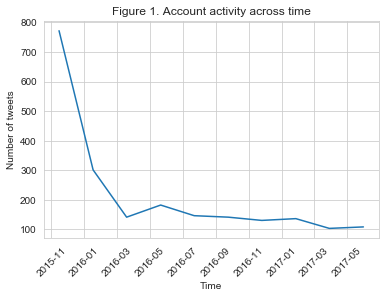

In [91]:
# Plot number of tweets on each period to find out whether account activity has increased or decreased overtime
plt.figure()
figsize=(12, 10)
plt.plot([b.date() for b in bins[:-1]],archive_df_sorted.groupby('timeSlot').tweet_id.count().values);
plt.title('Figure 1. Account activity across time')
plt.xlabel('Time')
plt.ylabel('Number of tweets')
plt.xticks(rotation=45);

Let's now see what happens with people's retweets over time. Do people retweet this account more now than in the past?

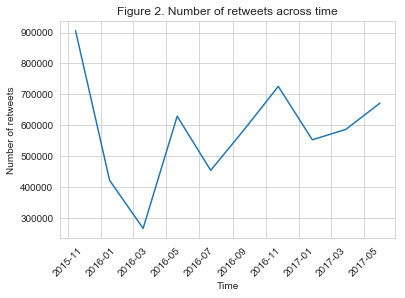

In [92]:
# Plot number of retweets over time
plt.figure()
figsize=(12, 10)
plt.plot([b.date() for b in bins[:-1]],archive_df_sorted.groupby('timeSlot').retw_count.sum().values);
plt.title('Figure 2. Number of retweets across time')
plt.xlabel('Time')
plt.ylabel('Number of retweets')
plt.xticks(rotation=45);

Similarly, with favourite.

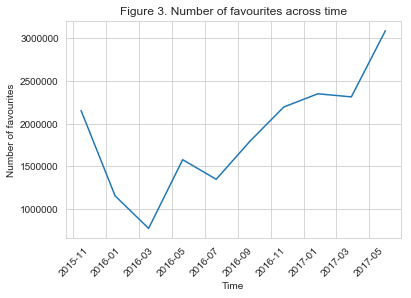

In [93]:
# Plot number of retweets over time
plt.figure()
figsize=(12, 10)
plt.plot([b.date() for b in bins[:-1]],archive_df_sorted.groupby('timeSlot').fav_count.sum().values);
plt.title('Figure 3. Number of favourites across time')
plt.xlabel('Time')
plt.ylabel('Number of favourites')
plt.xticks(rotation=45);

Now that we know that all denominators are 10, then we can analyse the numerator score only. I'll like to see the trend of dog-rating over time. Has it increased? Has the dog rater become more acquiescent...? 

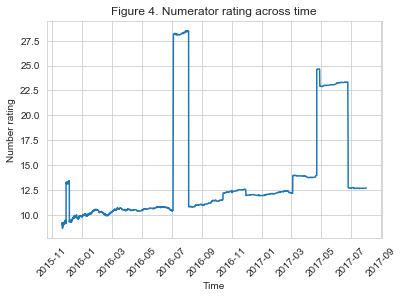

In [94]:
# Plot a MA of the numerator to see if scores are trending downwards or upwards
plt.figure()
figsize=(12, 10)
plt.plot(archive_df_sorted.timestamp, archive_df_sorted.rating_numerator.rolling(100).mean());
plt.title('Figure 4. Numerator rating across time')
plt.xlabel('Time')
plt.ylabel('Number rating')
plt.xticks(rotation=45);

Finally, I'd like to find out the degree of correlation between the following variables
- Rating numerator
- Favourite count
- Retweet count

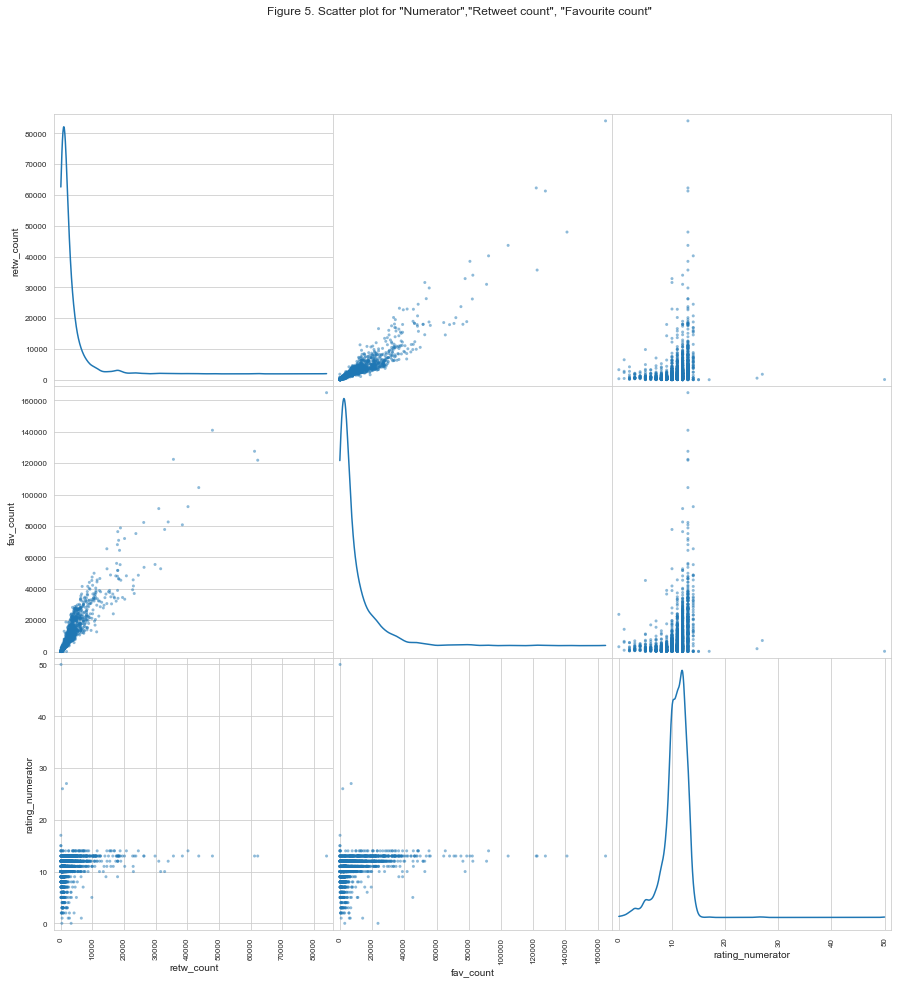

In [95]:
# Correlation between numerator and retw and fav
df_nooutliers = archive_df_sorted.drop(archive_df_sorted[archive_df_sorted['rating_numerator'] > 50].index )
df_corr = df_nooutliers[['retw_count','fav_count','rating_numerator']]
pd.plotting.scatter_matrix(df_corr, figsize=(15,15),diagonal='kde');
plt.suptitle('Figure 5. Scatter plot for "Numerator","Retweet count", "Favourite count"');